# Tracer le dashboard pour Bokeh 

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bokeh.models import ColumnDataSource, CustomJS, PrintfTickFormatter, Select
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook


# Data for Bokeh

In [68]:
def convert_cols(df):
    
    name_change = {'DAYS_EMPLOYED': 'YEARS_EMPLOYED', 'DAYS_BIRTH':'AGE',
                   'DAYS_LAST_PHONE_CHANGE':'YEARS_LAST_PHONE_CHANGE', 'AMT_ANNUITY':'AMT_ANNUITY_x1000',
                  'AMT_CREDIT': 'AMT_CREDIT_x10000'}
    if isinstance(df, pd.DataFrame):
        df = df.rename(columns = name_change)
    else:
        df = df.rename(name_change)
    df['YEARS_EMPLOYED'] = -df['YEARS_EMPLOYED']/365.25
    df['AGE'] = -df['AGE']/365.25
    df['YEARS_LAST_PHONE_CHANGE'] = -df['YEARS_LAST_PHONE_CHANGE']/365.25
    df['AMT_ANNUITY_x1000'] = df['AMT_ANNUITY_x1000']/1000
    df['AMT_CREDIT_x10000'] = df['AMT_CREDIT_x10000']/10000

    return df

In [69]:
# Creating data file for bokeh
train = pd.read_csv('../m_train.csv', index_col = 'SK_ID_CURR')

In [70]:
train = convert_cols(train)

cols = ['TARGET','previous_loan_counts','CREDIT_TERM','YEARS_EMPLOYED',
        'AMT_CREDIT_x10000','AMT_ANNUITY_x1000', 'AGE','YEARS_LAST_PHONE_CHANGE']

train.loc[:,cols].to_csv('../app/data/data-for-bokeh.csv', index = True)

data_for_bokeh = pd.read_csv('../app/data/data-for-bokeh.csv', index_col = 'SK_ID_CURR')

# Histogrammes pour prédictions

In [71]:
data_for_bokeh = pd.read_csv('../app/data/data-for-bokeh.csv', index_col = 'SK_ID_CURR')

In [72]:
def create_hist_column(df, column, target, bins, client_value):
    data_hist = {}
    index_names = ['[{}-{}['.format(bins[i],bins[i+1]) for i in range(len(bins)-1)]
    index_names.append('[{}+'.format(bins[-1]))
    data_hist['names'] = index_names
    data_hist['Default_percentage']= np.zeros((len(bins),1))
    
    
    data_hist['colors'] = ["#c9d9d3" for x in range(len(bins))]


    for i in range(len(bins)):
        if i != len(bins)-1:
            data_hist['colors'][i] = '#718dbf' if ((client_value >= bins[i]) & (client_value < bins[i+1])) else "#c9d9d3"
            if (df.loc[(df[column] >= bins[i]) & (df[column] < bins[i+1]),target].count() != 0):
                data_hist['Default_percentage'][i] = \
                100 * sum(df.loc[(df[column] >= bins[i]) & (df[column] < bins[i+1]),target])/df.loc[(df[column] >= bins[i]) & (df[column] < bins[i+1]),target].count()
        elif (df.loc[(df[column] >= bins[i]),target].count() != 0):
            data_hist['colors'][i] = '#718dbf' if (client_value >= bins[i]) else "#c9d9d3"

            data_hist['Default_percentage'][i] = \
            100 * sum(df.loc[(df[column] >= bins[i]),target])/df.loc[(df[column] >= bins[i]),target].count()
    
    
    
    return data_hist

In [73]:
def histograms_column(df, column, target, bins, client_value, title = 'Probability of default', xlabel = 'Range'):
    data_hist = create_hist_column(df, column, target, bins, client_value)

    xrange = data_hist["names"]

    # Creation des ColumnDataSource
    hist_CDS = ColumnDataSource(data = data_hist)
    
    # Info de la figure
    p = figure(x_range=xrange, plot_height=250, title=title,
               toolbar_location=None, tools="hover", 
               tooltips=[("Range","@{}".format('names')), ("Default Probability","@{} %".format('Default_percentage'))],
               x_axis_label=xlabel,
               y_axis_label="Risk of default (in %)")
    
    # Histograms
    vbar = p.vbar(top = 'Default_percentage', x="names", width=0.9, source=hist_CDS, color = "colors")

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    
    output_notebook()
    show(p)

In [74]:
id_client = 100001

In [75]:
def predict_credit(credit_id):
    import pandas as pd
    import lightgbm
    import pickle
    from bokeh.models.widgets import Div 
    """From credit_id, get the prediction of the credit failure or not
    If the credit_id does not exist, an error is shown"""
    try:
        test = pd.read_csv('../app/data/m_test.csv', index_col='SK_ID_CURR')
        x = test.loc[int(credit_id), :]
        # load the model from disk
        with open('../app/models/finalized_model_lgbm.sav', 'rb') as file:
            loaded_model = pickle.load(file)
        # Predict payment default
        result = loaded_model.predict(x.to_numpy().reshape(1, -1))
        proba = loaded_model.predict_proba(x.to_numpy().reshape(1, -1))
        if result[0]:
            name = 'DENIED.png'
        else:
            name = 'ACCEPTED.png'
        div_image = Div(text='<img src="/static/' + name + '">', height=200)
        #p = feature_importances(credit_id)
        #layouts = layout([[div_image], [p], ], sizing_mode="scale_height")
        
        return name, proba[:,1]
    except KeyError:
        return "Cet ID n'est pas présent dans notre base de données"

In [76]:
predict_credit(100005)

('DENIED.png', array([0.64623485]))

In [77]:
test = pd.read_csv('../app/data/m_test.csv', index_col='SK_ID_CURR')
x = test.loc[int(id_client), :]
x_mod = convert_cols(x)

## Credit Term

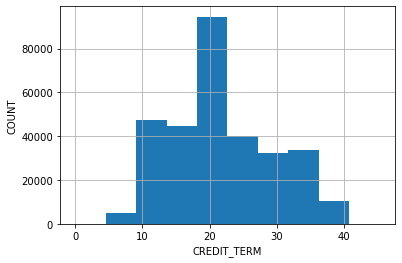

In [78]:
data_for_bokeh['CREDIT_TERM'].hist(bins = 10)
plt.xlabel('CREDIT_TERM')
plt.ylabel('COUNT');

In [79]:
bins = [x*5 for x in range(0,10)]
column = 'CREDIT_TERM'
histograms_column(data_for_bokeh,column,'TARGET',bins, x_mod[column])

Loading BokehJS ...

## YEARS_EMPLOYED

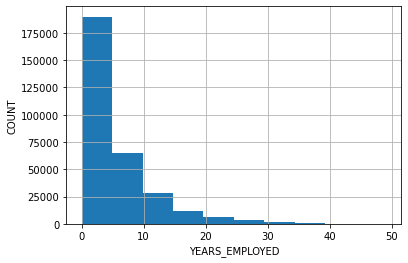

In [80]:
data_for_bokeh['YEARS_EMPLOYED'].hist(bins = 10)
plt.xlabel('YEARS_EMPLOYED')
plt.ylabel('COUNT');

In [81]:
bins = [x*5 for x in range(0,10)]
column = 'YEARS_EMPLOYED'
histograms_column(data_for_bokeh,column,'TARGET',bins, x_mod[column])

Loading BokehJS ...

## AGE

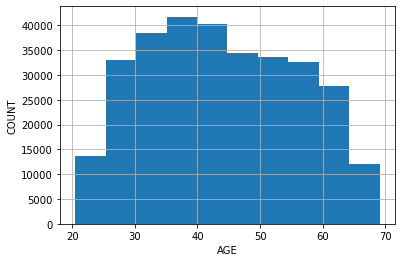

In [82]:
data_for_bokeh['AGE'].hist(bins = 10)
plt.xlabel('AGE')
plt.ylabel('COUNT');

In [83]:
bins = [21+x*5 for x in range(0,10)]
column = 'AGE'
histograms_column(data_for_bokeh,column,'TARGET',bins, x_mod[column])

Loading BokehJS ...

## AMT_ANNUITY

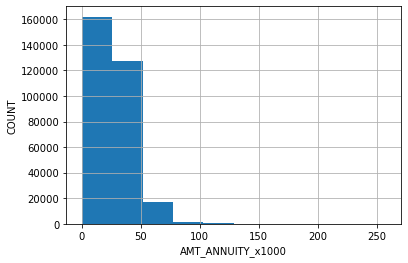

In [84]:
data_for_bokeh['AMT_ANNUITY_x1000'].hist(bins = 10)
plt.xlabel('AMT_ANNUITY_x1000')
plt.ylabel('COUNT');

In [85]:
bins = [x*10 for x in range(0,10)]
column = 'AMT_ANNUITY_x1000'
histograms_column(data_for_bokeh,column,'TARGET',bins, x_mod[column])

Loading BokehJS ...

## AMT_CREDIT

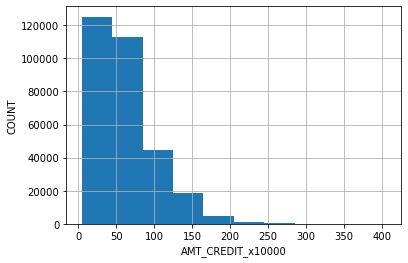

In [86]:
data_for_bokeh['AMT_CREDIT_x10000'].hist(bins = 10)
plt.xlabel('AMT_CREDIT_x10000')
plt.ylabel('COUNT');

In [87]:
bins = [x*30 for x in range(0,10)]
column = 'AMT_CREDIT_x10000'
histograms_column(data_for_bokeh,column,'TARGET',bins, x_mod[column])

Loading BokehJS ...

# Feature importance LGBM 

In [53]:
import pickle
test = pd.read_csv('../app/data/m_test.csv', index_col = 'SK_ID_CURR')
loaded_model = pickle.load(open('../app/models/finalized_model_lgbm.sav', 'rb'))

In [55]:
id_client = 100001

In [61]:
feature_importances = pd.DataFrame({'feature': list(test.columns), 
                                    'importance': loaded_model.feature_importances_})
feature_importances['relative_importance'] = 100* feature_importances['importance']/sum(feature_importances['importance'])
feature_importances = feature_importances.merge(test.loc[id_client,:].reset_index(), 
                                                left_on = 'feature', right_on = 'index').drop(columns = 'index').sort_values('importance',
ascending = False).head(7)

feature_importances

feature_importances = feature_importances.rename(columns = {id_client : 'value'})

# Convert columns to correct values
feature_importances.loc[feature_importances.feature=='DAYS_EMPLOYED','value'] = feature_importances.loc[feature_importances.feature=='DAYS_EMPLOYED','value']/-365.25
feature_importances.loc[feature_importances.feature=='DAYS_EMPLOYED','feature'] = 'YEARS_EMPLOYED'
feature_importances.loc[feature_importances.feature=='DAYS_BIRTH','value'] = feature_importances.loc[feature_importances.feature=='DAYS_BIRTH','value']/-365.25
feature_importances.loc[feature_importances.feature=='DAYS_BIRTH','feature'] = 'AGE'
feature_importances.loc[feature_importances.feature=='bureau_DAYS_CREDIT_max','value'] = feature_importances.loc[feature_importances.feature=='bureau_DAYS_CREDIT_max','value']/-365.25
feature_importances.loc[feature_importances.feature=='bureau_DAYS_CREDIT_max','feature'] = 'bureau_YEARS_CREDIT_max'
feature_importances.loc[feature_importances.feature=='DAYS_ID_PUBLISH','value'] = -feature_importances.loc[feature_importances.feature=='DAYS_ID_PUBLISH','value']/365.25
feature_importances.loc[feature_importances.feature=='DAYS_ID_PUBLISH','feature'] = 'YEARS_ID_PUBLISH'
feature_importances.loc[feature_importances.feature=='DAYS_LAST_PHONE_CHANGE','value'] = -feature_importances.loc[feature_importances.feature=='DAYS_LAST_PHONE_CHANGE','value']/365.25
feature_importances.loc[feature_importances.feature=='DAYS_LAST_PHONE_CHANGE','feature'] = 'YEARS_LAST_PHONE_CHANGE'



Names = {'CREDIT_TERM': 'Years of credit', 
        'client_installments_AMT_PAYMENT_min_sum' : 'Sum of the minimum amount the client paid on previous credits',
        'YEARS_EMPLOYED' : 'Years employed',
        'YEARS_LAST_PHONE_CHANGE': 'Years since last phone change',
        'AGE': 'Client age',
        'AMT_ANNUITY': 'Annuity payment',
        'AMT_CREDIT' :'Credit amount',
        'bureau_DAYS_CREDIT_max' : 'Maximum of years days before the client applied for Credit Bureau credit',
        'YEARS_ID_PUBLISH' : 'Years since the client applied'}

feature_importances['Name'] = feature_importances['feature'].map(Names)
feature_importances

,feature,importance,relative_importance,value,Name
0,CREDIT_TERM,1714,3.144954,16.461103,Years of credit
3,client_installments_AMT_PAYMENT_min_sum,872,1.600000,27746.775,Sum of the minimum amount the client paid on p...
2,YEARS_EMPLOYED,812,1.489908,6.376454,Years employed
5,YEARS_LAST_PHONE_CHANGE,807,1.480734,4.76386,Years since last phone change
1,AGE,735,1.348624,52.678987,Client age
4,AMT_ANNUITY,709,1.300917,20560.5,Annuity payment
9,AMT_CREDIT,659,1.209174,568800.0,Credit amount


In [108]:
bins = [x*5 for x in range(0,10)]
histograms_column(data_for_bokeh,'CREDIT_TERM','TARGET',bins, 14)

Loading BokehJS ...

In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [23]:
import pandas as pd
data_for_bokeh = pd.read_csv('../app/data/data-for-bokeh.csv', index_col = 'SK_ID_CURR')

data_for_bokeh['YEARS_EMPLOYED'] = data_for_bokeh['DAYS_EMPLOYED']/-365.25
data_for_bokeh['CLIENT_AGE'] = data_for_bokeh['DAYS_BIRTH']/-365.25

In [45]:
df = data_for_bokeh
column = 'CLIENT_AGE'
target = "TARGET"

data_hist = {}
bins = [x*5 for x in range(0,14)]
index_names = ['[{}-{}['.format(bins[i],bins[i+1]) for i in range(len(bins)-1)]
index_names[-1] = '[{}+'.format(bins[-1])
data_hist['names'] = index_names
data_hist['Default_percentage']= np.zeros((len(bins),1))

for i in range(len(bins)-1):
    if (df.loc[(df[column] >= bins[i]) & (df[column] < bins[i+1]),target].count() != 0):
        data_hist['Default_percentage'][i] = \
        100 * sum(df.loc[(df[column] >= bins[i]) & (df[column] < bins[i+1]),target])/df.loc[(df[column] >= bins[4]) & (df[column] < bins[5]),target].count()
data_hist

{'names': ['[0-5[',
  '[5-10[',
  '[10-15[',
  '[15-20[',
  '[20-25[',
  '[25-30[',
  '[30-35[',
  '[35-40[',
  '[40-45[',
  '[45-50[',
  '[50-55[',
  '[55-60[',
  '[65+'],
 'Default_percentage': array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [12.29461293],
        [29.97629363],
        [33.13986757],
        [31.41502493],
        [26.50208453],
        [21.34390583],
        [19.08771356],
        [14.98405951],
        [11.83683479],
        [ 0.        ]])}

In [51]:
import numpy as np

from bokeh.layouts import column, grid
from bokeh.models import ColumnDataSource, CustomJS, PrintfTickFormatter, Select
from bokeh.plotting import figure, output_file, show
from bokeh.models.tools import HoverTool
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.io import output_notebook


tools = 'pan'


def Number_of_credits():
    
    data = pd.DataFrame(data_for_bokeh.TARGET.value_counts()).reset_index()
    data['percent'] = data['TARGET']/sum(data['TARGET'])*100
    data['index'] = data['index'].astype(str).replace({'True': 'Default', 'False':'No Default'})
    values = data['index'].unique()


    p = figure(x_range=values, plot_height=200, title="Number of contracts", tools=[HoverTool()],
    tooltips="@index : @TARGET (@percent{0.2f} %)",
           toolbar_location=None)

    p.vbar(x="index", top="TARGET", width=0.6, source=data)

    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    p.yaxis[0].formatter = PrintfTickFormatter(format="%6.0f")

    return [p]


def table_previous_loans():
    source = ColumnDataSource(data_for_bokeh.sort_values(by = 'previous_loan_counts', ascending = False).head(10))

    columns = [
        TableColumn(field="SK_ID_CURR", title="SK_ID_CURR"),
        TableColumn(field="previous_loan_counts", title="previous_loan_counts"),
    ]
    data_table = DataTable(source=source, columns=columns, width=400, height=280)

    return [data_table]




def histograms():
    
    def create_hist(df, column, target):
        data_hist = {}
        bins = [x*5 for x in range(0,14)]
        index_names = ['[{}-{}['.format(bins[i],bins[i+1]) for i in range(len(bins)-1)]
        index_names[-1] = '[{}+'.format(bins[-1])
        data_hist['names'] = index_names

        for t in df[target].unique():
            series_temp = df.loc[df[target] == t,column]
            hist = np.histogram(series_temp, bins=bins)
            if t:
                data_hist["Default"] = hist[0]
            else: 
                data_hist["No Default"] = hist[0]
        
        data_hist['Default_percentage'] = 100 * data_hist["Default"]/(data_hist["Default"] + data_hist["No Default"])


        return data_hist
    
    data_hist_AGE = create_hist(data_for_bokeh, "CLIENT_AGE", "TARGET")
    data_hist_CREDIT = create_hist(data_for_bokeh, "CREDIT_TERM", "TARGET")
    data_hist_YEARS = create_hist(data_for_bokeh, "YEARS_EMPLOYED", "TARGET")


    xrange = data_hist_AGE["names"]
    colors = ["#c9d9d3", "#718dbf"]
    #target = ["Default","No Default"]
    names = [0,10,20,30,40,50,60]

    # Creation des histogrammes
    hist_AGE_CDS = ColumnDataSource(data = data_hist_AGE)
    hist_CREDIT_CDS = ColumnDataSource(data = data_hist_CREDIT)
    hist_YEARS_CDS = ColumnDataSource(data = data_hist_YEARS)

    # Dummy pour remplir l'histogramme dans un premier temps
    source_dummy = ColumnDataSource(data = data_hist_AGE)

    source = source_dummy
    
    p = figure(x_range=xrange, plot_height=250, title="Number of clients by age",
               toolbar_location=None, tools="hover", 
               tooltips=[("Range","@{}".format('names')), ("Number","@$name")],
               x_axis_label="Age range (in years)",
               y_axis_label="Count")
    
    # Histograms
    vbar = p.vbar_stack(target, x="names", width=0.9, color=colors, source=source,
                 legend_label=target)

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.location = "top_right"
    p.legend.orientation = "horizontal"
    
    # Menu de sélection
    # Actions lors du changement

    handler = CustomJS(args=dict(source=source,  
                                 hist_AGE_CDS = hist_AGE_CDS, hist_CREDIT_CDS=hist_CREDIT_CDS,
                                hist_YEARS_CDS = hist_YEARS_CDS), code="""

        if (cb_obj.value=="Clients age") {
          source.data = hist_AGE_CDS.data
        } else if (cb_obj.value=='Credit Term'){
          source.data = hist_CREDIT_CDS.data
        } else {
          source.data = hist_YEARS_CDS.data
        }
        """)

    handler_2 = CustomJS(args=dict(xaxis=p.xaxis[0]), code="""

        if (cb_obj.value=="Clients age") {
          xaxis.axis_label = 'Age range (in years)'
        } else if (cb_obj.value=='Credit Term'){
          xaxis.axis_label = 'Years of credit'
        } else {
          xaxis.axis_label = 'Years employed'
        }
        """)

    handler_3 = CustomJS(args=dict(p = p ), code="""

        if (cb_obj.value=="Clients age") {
          p.title.text = 'Number of clients by age'
        } else if (cb_obj.value=='Credit Term'){
          p.title.text = 'Number of clients by credit term'
        } else {
          p.title.text = 'Number of clients by years employed'
        }
        """)
    
    # Selecteur
    select = Select(title="Value to show:", options=["Clients age",'Credit Term','Years employed'])
    select.js_on_change('value', handler)
    select.js_on_change('value', handler_2)
    select.js_on_change('value', handler_3)



    return [column(select, p)]

def histograms_2():
    
    def create_hist_2(df, column, target):
        data_hist = {}
        bins = [x*5 for x in range(0,14)]
        index_names = ['[{}-{}['.format(bins[i],bins[i+1]) for i in range(len(bins)-1)]
        index_names[-1] = '[{}+'.format(bins[-1])
        data_hist['names'] = index_names
        data_hist['Default_percentage']= np.zeros((len(bins)-1,1))

        for i in range(len(bins)-1):
            if (df.loc[(df[column] >= bins[i]) & (df[column] < bins[i+1]),target].count() != 0):
                data_hist['Default_percentage'][i] = \
                100 * sum(df.loc[(df[column] >= bins[i]) & (df[column] < bins[i+1]),target])/df.loc[(df[column] >= bins[i]) & (df[column] < bins[i+1]),target].count()
        return data_hist
    
    data_hist_AGE = create_hist_2(data_for_bokeh, "CLIENT_AGE", "TARGET")
    data_hist_CREDIT = create_hist_2(data_for_bokeh, "CREDIT_TERM", "TARGET")
    data_hist_YEARS = create_hist_2(data_for_bokeh, "YEARS_EMPLOYED", "TARGET")


    xrange = data_hist_AGE["names"]
    #colors = ["#c9d9d3", "#718dbf"]
    #target = ["Default","No Default"]
    #names = [0,10,20,30,40,50,60]

    # Creation des histogrammes
    hist_AGE_CDS = ColumnDataSource(data = data_hist_AGE)
    hist_CREDIT_CDS = ColumnDataSource(data = data_hist_CREDIT)
    hist_YEARS_CDS = ColumnDataSource(data = data_hist_YEARS)

    # Dummy pour remplir l'histogramme dans un premier temps
    source_dummy = ColumnDataSource(data = data_hist_AGE)

    source = source_dummy
    
    p = figure(x_range=xrange, plot_height=250, title="Number of clients by age",
               toolbar_location=None, tools="hover", 
               tooltips=[("Range","@{}".format('names')), ("Default Probability","@{} %".format('Default_percentage'))],
               x_axis_label="Age range (in years)",
               y_axis_label="Risk of default (in %)")
    
    # Histograms
    vbar = p.vbar(top = 'Default_percentage', x="names", width=0.9, source=source)

    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    #p.legend.location = "top_right"
    #p.legend.orientation = "horizontal"
    
    # Menu de sélection
    # Actions lors du changement

    handler = CustomJS(args=dict(source=source,  
                                 hist_AGE_CDS = hist_AGE_CDS, hist_CREDIT_CDS=hist_CREDIT_CDS,
                                hist_YEARS_CDS = hist_YEARS_CDS), code="""

        if (cb_obj.value=="Clients age") {
          source.data = hist_AGE_CDS.data
        } else if (cb_obj.value=='Credit Term'){
          source.data = hist_CREDIT_CDS.data
        } else {
          source.data = hist_YEARS_CDS.data
        }
        """)

    handler_2 = CustomJS(args=dict(xaxis=p.xaxis[0]), code="""

        if (cb_obj.value=="Clients age") {
          xaxis.axis_label = 'Age range (in years)'
        } else if (cb_obj.value=='Credit Term'){
          xaxis.axis_label = 'Years of credit'
        } else {
          xaxis.axis_label = 'Years employed'
        }
        """)

    handler_3 = CustomJS(args=dict(p = p ), code="""

        if (cb_obj.value=="Clients age") {
          p.title.text = 'Percentage of default by age'
        } else if (cb_obj.value=='Credit Term'){
          p.title.text = 'Percentage of default by credit term'
        } else {
          p.title.text = 'Percentage of default by years employed'
        }
        """)
    
    # Selecteur
    select = Select(title="Value to show:", options=["Clients age",'Credit Term','Years employed'])
    select.js_on_change('value', handler)
    select.js_on_change('value', handler_2)
    select.js_on_change('value', handler_3)



    return [column(select, p)]


l = grid([
    [Number_of_credits(),
    table_previous_loans()],
    histograms_2(),
], sizing_mode='stretch_both')

output_notebook()
show(l)

Loading BokehJS ...

# Credit acceptance of not - Bokeh

In [17]:
def predict_credit(credit_id):
    import pandas as pd
    import lightgbm
    import pickle
    """From credit_id, get the prediction of the credit failure or not
    If the credit_id does not exist, an error is shown"""
    try:
        test = pd.read_csv('../app/data/m_test.csv', index_col='SK_ID_CURR')
        x = test.loc[int(credit_id), :]
        # load the model from disk
        with open('../app/models/finalized_model.sav', 'rb') as file:
            loaded_model = pickle.load(file)
        # Predict payment default
        result = loaded_model.predict(x.to_numpy().reshape(1, -1))
        proba = loaded_model.predict_proba(x.to_numpy().reshape(1, -1))
        if result[0]:
            name = 'DENIED.png'
        else:
            name = 'ACCEPTED.png'
        div_image = Div(text='<img src="/static/' + name + '">', height=200)
        p = feature_importances(credit_id)
        layouts = layout([[div_image], [p], ], sizing_mode="scale_height")
        
        return name, proba
    except KeyError:
        return "Cet ID n'est pas présent dans notre base de données"

In [18]:
id_client = 100005
predict_credit(id_client)

ValueError: Number of features of the model must match the input. Model n_features_ is 346 and input n_features is 339 

In [95]:
import pickle
test = pd.read_csv('app/data/m_test.csv', index_col = 'SK_ID_CURR')
loaded_model = pickle.load(open('app/models/finalized_model.sav', 'rb'))

In [96]:
feature_importances = pd.DataFrame({'feature': list(test.columns), 
                                    'importance': loaded_model.feature_importances_})
feature_importances = feature_importances.merge(test.loc[id_client,:].reset_index(), 
                                                left_on = 'feature', right_on = 'index').drop(columns = 'index').sort_values('importance',
ascending = False).head(10)


feature_importances = feature_importances.rename(columns = {id_client : 'value'})
feature_importances['Name'] = ['Years of credit', 'Years employed', 'Days since last phone change', 'Age', 
                              'What the client actually paid on previous credit on this installment(sum of minimum)', 'Annuity payment','Credit amount',
                              'Installments left to pay on the previous credit (max of mean)',
                               'How many days before current application did client apply for Credit Bureau credit (max)',
                              'How many days before the application did client change the identity document with which he applied for the loan']

# Convert columns to correct values
feature_importances.loc[feature_importances.feature=='DAYS_EMPLOYED','value'] = feature_importances.loc[feature_importances.feature=='DAYS_EMPLOYED','value']/-365.25
feature_importances.loc[feature_importances.feature=='DAYS_EMPLOYED','feature'] = 'YEARS_EMPLOYED'
feature_importances.loc[feature_importances.feature=='DAYS_BIRTH','value'] = feature_importances.loc[feature_importances.feature=='DAYS_BIRTH','value']/-365.25
feature_importances.loc[feature_importances.feature=='DAYS_BIRTH','feature'] = 'AGE'
feature_importances.loc[feature_importances.feature=='bureau_DAYS_CREDIT_max','value'] = -feature_importances.loc[feature_importances.feature=='bureau_DAYS_CREDIT_max','value']
feature_importances.loc[feature_importances.feature=='DAYS_ID_PUBLISH','value'] = -feature_importances.loc[feature_importances.feature=='DAYS_ID_PUBLISH','value']
feature_importances.loc[feature_importances.feature=='DAYS_LAST_PHONE_CHANGE','value'] = -feature_importances.loc[feature_importances.feature=='DAYS_LAST_PHONE_CHANGE','value']


feature_importances

,feature,importance,value,Name
0,CREDIT_TERM,1649,36.234085,Years of credit
2,YEARS_EMPLOYED,699,12.235455,Years employed
4,DAYS_LAST_PHONE_CHANGE,671,0.0,Days since last phone change
1,AGE,614,49.456537,Age
5,client_installments_AMT_PAYMENT_min_sum,599,43318.8,What the client actually paid on previous cred...
3,AMT_ANNUITY,569,17370.0,Annuity payment
8,AMT_CREDIT,544,222768.0,Credit amount
12,client_cash_CNT_INSTALMENT_FUTURE_mean_max,527,7.2,Installments left to pay on the previous credi...
9,bureau_DAYS_CREDIT_max,516,62.0,How many days before current application did c...
6,DAYS_ID_PUBLISH,510,1623,How many days before the application did clien...


In [114]:
from bokeh.models.widgets import Div

if predict_credit(100005) == "CRÉDIT REFUSÉ":
    name = 'DENIED.png'
    div_image = Div(text='<img src="app/static/ACCEPTED.png">', width=400, height = 100)
    output_notebook()
    show(div_image)

Loading BokehJS ...

In [105]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral10
from bokeh.plotting import figure
from bokeh.layouts import row

yrange = feature_importances.sort_values(by ='importance').feature.to_list()
source = ColumnDataSource(data=feature_importances)
source.data['color']= Spectral10
p = figure(y_range=yrange, x_range=(300,1700), plot_height=400, title="Features importance",
           tools=[HoverTool()], tooltips="@Name : @value{f}",
           toolbar_location=None)

p.hbar(y='feature', right='importance', height=0.9, color='color', source=source)

p.xgrid.grid_line_color = None
output_notebook()
show(row(div_image, p))

Loading BokehJS ...

In [58]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral10
from bokeh.plotting import figure

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
counts = [5, 3, 4, 2, 4, 6]

source = ColumnDataSource(data=dict(fruits=fruits, counts=counts, color=Spectral6))

p = figure(x_range=fruits, y_range=(0,9), plot_height=250, title="Fruit counts",
           tools=[HoverTool()], tooltips="@Name : @value",
           toolbar_location=None)

p.vbar(x='fruits', top='counts', width=0.9, color='color', legend_field="fruits", source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"
output_notebook()
show(p)

Loading BokehJS ...

In [35]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.models.tools import HoverTool


data = pd.DataFrame(data_for_bokeh.TARGET.value_counts()).reset_index()
data['percent'] = data['TARGET']/sum(data['TARGET'])*100
data['index'] = data['index'].astype(str).replace({'True': 'Default', 'False':'No Default'})
values = data['index'].unique()




p = figure(x_range=values, plot_height=200, title="Number of contracts", tools=[HoverTool()],
    tooltips="@index : @TARGET (@percent{0.2f} %)",
           toolbar_location=None)

p.vbar(x="index", top="TARGET", width=0.6, source=data)

p.xgrid.grid_line_color = None
p.y_range.start = 0

p.yaxis[0].formatter = PrintfTickFormatter(format="%6.0f")
#p.toolbar.autohide = False

# Set to output the plot in the notebook
output_notebook()

show(p)

Loading BokehJS ...

In [197]:
def create_hist(df, column, target):
    data_hist = {}
    bins = [x*5 for x in range(0,14)]
    index_names = ['[{}-{}['.format(bins[i],bins[i+1]) for i in range(len(bins)-1)]
    index_names[-1] = '[{}+'.format(bins[-1])
    data_hist['names'] = index_names

    for t in df[target].unique():
        series_temp = df.loc[df[target] == t,column]
        hist = np.histogram(series_temp, bins=bins)
        if t:
            data_hist["Default"] = hist[0]
        else: 
            data_hist["No Default"] = hist[0]

        
    return data_hist

In [198]:
hist_client_age = create_hist(data_for_bokeh, "CLIENT_AGE", "TARGET")
hist_client_age

{'names': ['[0-5[',
  '[5-10[',
  '[10-15[',
  '[15-20[',
  '[20-25[',
  '[25-30[',
  '[30-35[',
  '[35-40[',
  '[40-45[',
  '[45-50[',
  '[50-55[',
  '[55-60[',
  '[65+'],
 'Default': array([   0,    0,    0,    0, 1504, 3667, 4054, 3843, 3242, 2611, 2335,
        1833, 1448]),
 'No Default': array([    0,     0,     0,     0, 10729, 29286, 35422, 39012, 38164,
        32582, 32662, 31264, 25977])}

In [199]:
def hist_plot(df, column, title):
    
    data_hist = create_hist(data_for_bokeh, column, "TARGET")

    xrange = data_hist['names']
    colors = ["#c9d9d3", "#718dbf"]
    target = ["Default","No Default"]
    #names = [0,10,20,30,40,50,60]

    
    data_bokeh = ColumnDataSource(data = data_hist)
    p = figure(x_range=xrange, plot_height=250, title=title,
               toolbar_location=None, tools="hover", tooltips=[("Range","@{}".format('names')), ("Number","@$name")],)
                                                               
#('Range','@{}'.format(column)),('$name', '@$name')]                                                               
#"Range : @{} \n $name : @$name".format(column)
    p.vbar_stack(target, x='names', width=0.9, color=colors, source=data_bokeh,
                 legend_label=target)
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.location = "top_right"
    p.legend.orientation = "horizontal"

    show(p)
    
hist_plot(data_for_bokeh, "CLIENT_AGE", "Number of clients by age range")

In [200]:
hist_plot(data_for_bokeh, "YEARS_EMPLOYED", "Number of clients by years employed range")

In [201]:
hist_plot(data_for_bokeh, "CREDIT_TERM", "Number of clients by years employed range")

In [220]:
data_hist_AGE = create_hist(data_for_bokeh, "CLIENT_AGE", "TARGET")
data_hist_CREDIT = create_hist(data_for_bokeh, "CREDIT_TERM", "TARGET")
data_hist_YEARS = create_hist(data_for_bokeh, "YEARS_EMPLOYED", "TARGET")


xrange = data_hist_AGE["names"]
colors = ["#c9d9d3", "#718dbf"]
target = ["Default","No Default"]
names = [0,10,20,30,40,50,60]


hist_AGE_CDS = ColumnDataSource(data = data_hist_AGE)
hist_CREDIT_CDS = ColumnDataSource(data = data_hist_CREDIT)
hist_YEARS_CDS = ColumnDataSource(data = data_hist_YEARS)

source_dummy = ColumnDataSource(data = data_hist_AGE)

source = source_dummy
p = figure(x_range=xrange, plot_height=250, title="Number of clients by age",
           toolbar_location=None, tools="hover", 
           tooltips=[("Range","@{}".format('names')), ("Number","@$name")],
           x_axis_label="Age range (in years)",
           y_axis_label="Count")

vbar = p.vbar_stack(target, x="names", width=0.9, color=colors, source=source,
             legend_label=target)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "horizontal"


handler = CustomJS(args=dict(source=source,  
                             hist_AGE_CDS = hist_AGE_CDS, hist_CREDIT_CDS=hist_CREDIT_CDS,
                            hist_YEARS_CDS = hist_YEARS_CDS), code="""
    
    if (cb_obj.value=="Clients age") {
      source.data = hist_AGE_CDS.data
    } else if (cb_obj.value=='Credit Term'){
      source.data = hist_CREDIT_CDS.data
    } else {
      source.data = hist_YEARS_CDS.data
    }
    """)

handler_2 = CustomJS(args=dict(xaxis=p.xaxis[0]), code="""
    
    if (cb_obj.value=="Clients age") {
      xaxis.axis_label = 'Age range (in years)'
    } else if (cb_obj.value=='Credit Term'){
      xaxis.axis_label = 'Years of credit'
    } else {
      xaxis.axis_label = 'Years employed'
    }
    """)

handler_3 = CustomJS(args=dict(p = p ), code="""
    
    if (cb_obj.value=="Clients age") {
      p.title.text = 'Number of clients by age'
    } else if (cb_obj.value=='Credit Term'){
      p.title.text = 'Number of clients by credit term'
    } else {
      p.title.text = 'Number of clients by years employed'
    }
    """)

select = Select(title="Value to show:", options=["Clients age",'Credit Term','Years employed'])
select.js_on_change('value', handler)
select.js_on_change('value', handler_2)
select.js_on_change('value', handler_3)



show(column(select, p))

In [143]:
import numpy as np

from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS, Select
from bokeh.plotting import figure

x = np.linspace(0, 10, 100)
foo = x**2
bar = np.sin(x)

source = ColumnDataSource(data=dict(x=x, y=foo, foo=foo, bar=bar))

plot = figure(plot_height=350)
plot.line(x='x', y='y', source=source)

select = Select(value='foo', options=['foo', 'bar'])
select.js_on_change('value', CustomJS(args=dict(source_1=source, select_a=select), code="""
    // make a shallow copy of the current data dict
    const new_data = Object.assign({}, source_1.data)

    // update the y column in the new data dict from the appropriate other column
    new_data.y = source_1.data[select_a.value]

    // set the new data on source, BokehJS will pick this up automatically
    source_1.data = new_data
"""))



show(column(plot, select))

In [83]:
from bokeh.io import output_file, show
from bokeh.plotting import figure

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
years = ["2015", "2016", "2017"]
colors = ["#c9d9d3", "#718dbf", "#e84d60"]

data = {'fruits' : fruits,
        '2015'   : [2, 1, 4, 3, 2, 4],
        '2016'   : [5, 3, 4, 2, 4, 6],
        '2017'   : [3, 2, 4, 4, 5, 3]}

p = figure(x_range=fruits, plot_height=250, title="Fruit counts by year",
           toolbar_location=None, tools="hover", tooltips="$name @fruits: @$name")

p.vbar_stack(years, x='fruits', width=0.9, color=colors, source=data,
             legend_label=years)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

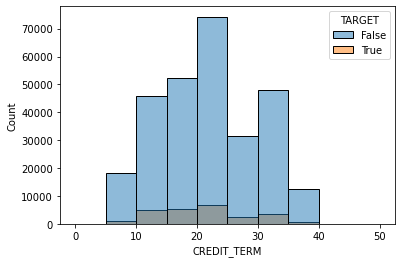

In [36]:
import seaborn as sns 

sns.histplot(x="CREDIT_TERM", hue="TARGET", data=data_for_bokeh, binwidth = 5);

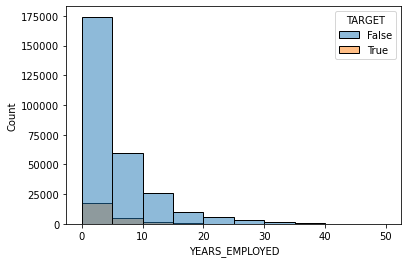

In [37]:
data_for_bokeh['YEARS_EMPLOYED'] = data_for_bokeh['DAYS_EMPLOYED']/-365.25

sns.histplot(x="YEARS_EMPLOYED", hue="TARGET", data=data_for_bokeh,binwidth = 5);

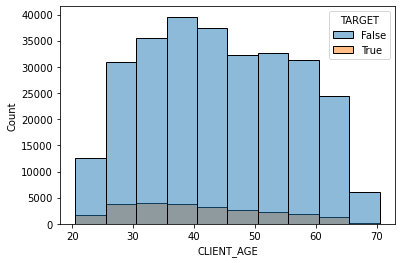

In [38]:
data_for_bokeh['CLIENT_AGE'] = data_for_bokeh['DAYS_BIRTH']/-365.25
sns.histplot(x="CLIENT_AGE", hue="TARGET", data=data_for_bokeh,binwidth = 5);

In [ ]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, output_file, show

output_file("hbar_stack.html")

source = ColumnDataSource(data=dict(
    y=[1, 2, 3, 4, 5],
    x1=[1, 2, 4, 3, 4],
    x2=[1, 4, 2, 2, 3],
))
p = figure(plot_width=400, plot_height=400)

p.hbar_stack(['x1', 'x2'], y='y', height=0.8, color=("grey", "lightgrey"), source=source)

show(p)

In [12]:
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, TableColumn

source = ColumnDataSource(data_for_bokeh.sort_values(by = 'previous_loan_counts', ascending = False).head(10))

columns = [
    TableColumn(field="SK_ID_CURR", title="SK_ID_CURR"),
    TableColumn(field="previous_loan_counts", title="previous_loan_counts"),
]
data_table = DataTable(source=source, columns=columns, width=400, height=280)

show(data_table)

In [13]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import PrintfTickFormatter,CustomJS,Select
from bokeh.layouts import column
from bokeh.plotting import figure
from bokeh.models.tools import HoverTool


data = pd.DataFrame(data_for_bokeh.TARGET.value_counts()).reset_index()
data['percent'] = data['TARGET']/sum(data['TARGET'])*100
data['index'] = data['index'].astype(str).replace({'True': 'Default', 'False':'No Default'})
data['test'] = [50,50]
values = data['index'].unique()

p = figure(x_range=values, plot_height=200, title="Number of contracts", tools=[HoverTool()],
tooltips="@index : @TARGET (@percent{0.2f} %)",
       toolbar_location=None)

vbar = p.vbar(x="index", top="percent", width=0.6, source=data)

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.yaxis[0].formatter = PrintfTickFormatter(format="%6.0f")


handler = CustomJS(args=dict(vbar=vbar), code="""
   vbar.glyph.top = {field: cb_obj.value};
""")

select = Select(title="df-column:", options=['percent','TARGET','test'])
select.js_on_change('value', handler)

show(column(select, p))

In [14]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange, CustomJS, Select
from bokeh.plotting import figure

#output_file("bars.html")

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
years = ['2015', '2016', '2017']

data = {'fruits' : fruits,
        '2015'   : [2, 1, 4, 3, 2, 4],
        '2016'   : [5, 3, 3, 2, 4, 6],
        '2017'   : [3, 2, 4, 4, 5, 3]}

# this creates [ ("Apples", "2015"), ("Apples", "2016"), ("Apples", "2017"), ("Pears", "2015), ... ]
x = [ (fruit, year) for fruit in fruits for year in years ]
counts = sum(zip(data['2015'], data['2016'], data['2017']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p = figure(x_range=FactorRange(*x), plot_height=250, title="Fruit counts by year",
           toolbar_location=None, tools="")

p.vbar(x='x', top='counts', width=0.9, source=source)

#p.y_range.start = 0
#p.x_range.range_padding = 0.1
#p.xaxis.major_label_orientation = 1
#p.xgrid.grid_line_color = None

show(p)

In [15]:
import pandas as pd

from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.models import Select
from bokeh.models.tools import HoverTool
from bokeh.plotting import figure

df = pd.DataFrame({'2007': [10, 20, 30, 40],
                   '2008': [90, 60, 70, 40],
                   '2009': [30, 60, 70, 10],
                   '2010': [80, 50, 30, 10]},
                  index=[0, 0.5, 1, 1.5])
ds = ColumnDataSource(df)
p = figure(toolbar_location="above", x_axis_type="linear")
p.add_tools(HoverTool(tooltips=[("y", "@index")]))

line_renderer = p.line('2007', 'index', source=ds)

handler = CustomJS(args=dict(line_renderer=line_renderer), code="""
   line_renderer.glyph.x = {field: cb_obj.value};
""")

select = Select(title="df-column:", options=list(df.columns))
select.js_on_change('value', handler)

show(column(select, p))

In [134]:
d1 = {'time': [1,2,3,4], 'y': [2,4,6,8]}
d2 = {'time': [1,2,3,4,5], 'y': [2,1,1,8,22]}

source = ColumnDataSource(d1)

p = figure()
r = p.vbar(x='time', top='y', width=1,
         source = source)

handler = CustomJS(args=dict(r=r), code="""
   r.glyph.x = {field: cb_obj.value};
""")


select = Select(title="monthly csv-s", value = 'd1', options=['d1', 'd2'])


In [135]:
print(p.x)

<bound method Figure.x of Figure(id='10353', ...)>


In [18]:
import numpy as np

from bokeh.layouts import column, grid
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.plotting import figure, output_file, show

#output_file('dashboard.html')

tools = 'pan'


def Number_of_credits():
    
    data = pd.DataFrame(data_for_bokeh.TARGET.value_counts()).reset_index()
    data['percent'] = data['TARGET']/sum(data['TARGET'])*100
    data['index'] = data['index'].astype(str).replace({'True': 'Default', 'False':'No Default'})
    values = data['index'].unique()


    p = figure(x_range=values, plot_height=200, title="Number of contracts", tools=[HoverTool()],
    tooltips="@index : @TARGET (@percent{0.2f} %)",
           toolbar_location=None)

    p.vbar(x="index", top="TARGET", width=0.6, source=data)

    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    p.yaxis[0].formatter = PrintfTickFormatter(format="%6.0f")

    return [p]


def table_previous_loans():
    source = ColumnDataSource(data_for_bokeh.sort_values(by = 'previous_loan_counts', ascending = False).head(10))

    columns = [
        TableColumn(field="SK_ID_CURR", title="SK_ID_CURR"),
        TableColumn(field="previous_loan_counts", title="previous_loan_counts"),
    ]
    data_table = DataTable(source=source, columns=columns, width=400, height=280)

    return [data_table]


def linked_panning():
    N = 100
    x = np.linspace(0, 4 * np.pi, N)
    y1 = np.sin(x)
    y2 = np.cos(x)
    y3 = np.sin(x) + np.cos(x)

    s1 = figure(tools=tools)
    s1.circle(x, y1, color="navy", size=8, alpha=0.5)
    s2 = figure(tools=tools, x_range=s1.x_range, y_range=s1.y_range)
    s2.circle(x, y2, color="firebrick", size=8, alpha=0.5)
    s3 = figure(tools='pan, box_select', x_range=s1.x_range)
    s3.circle(x, y3, color="olive", size=8, alpha=0.5)
    return [s1, s2, s3]

l = grid([
    [Number_of_credits(),
    table_previous_loans()],
    linked_panning(),
], sizing_mode='stretch_both')

output_notebook()
show(l)

<AxesSubplot:xlabel='AMT_ANNUITY', ylabel='Count'>

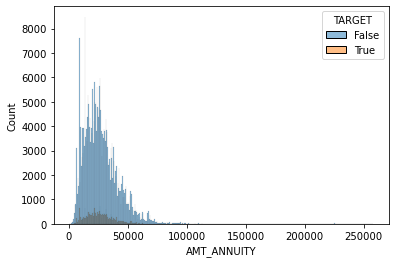

In [19]:
import seaborn as sns 

sns.histplot(x="AMT_ANNUITY", hue="TARGET", data=data_for_bokeh)

In [20]:
from bokeh.io import show
from bokeh.models import CustomJS, Select

select = Select(title="Option:", value="foo", options=["foo", "bar", "baz", "quux"])
select.js_on_change("value", CustomJS(code="""
    console.log('select: value=' + this.value, this.toString())
"""))

output_notebook()

show(select)

Loading BokehJS ...

In [21]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models.widgets import Select
from bokeh.io import curdoc
from bokeh.layouts import column, row

d1 = {'time': [1,2,3,4], 'y': [2,4,6,8]}
d2 = {'time': [1,2,3,4,5], 'y': [2,1,1,8,22]}

source = ColumnDataSource(d1)

p = figure()
r = p.vbar(x='time', top='y', width=1,
         source = source)

select = Select(title="monthly csv-s", value = 'd1', options=['d1', 'd2'])

def update_plot(attrname, old, new):
    if select.value == 'd1':
        newSource = d1
    if select.value == 'd2':
        newSource = d2
    source.data =  newSource 


select.js_on_change('value', update_plot)
layout = column(row(select, width=400), p)
show(layout)

ValueError: not all callback values are CustomJS instances

In [133]:
from bokeh.layouts import layout
from bokeh.models import Div, RangeSlider, Spinner
from bokeh.plotting import figure, show

# prepare some data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [4, 5, 5, 7, 2, 6, 4, 9, 1, 3]

# create plot with circle glyphs
p = figure(x_range=(1, 9), plot_width=500, plot_height=250, title = 'COOL')
points = p.circle(x=x, y=y, size=30, fill_color="#21a7df")

# set up textarea (div)
div = Div(
    text="""
          <p>Select the circle's size using this control element:</p>
          """,
    width=200,
    height=30,
)


#select = Select(title="monthly csv-s",  options=['d1', 'd2'])

# set up spinner
spinner = Select(
    title="Circle size",
    options = ['30', '50', '60'],
    value="30",
    width=200,
)

spinner.js_link("value", p.title, 'text')

# set up RangeSlider
range_slider = RangeSlider(
    title="Adjust x-axis range",
    start=0,
    end=10,
    step=1,
    value=(p.x_range.start, p.x_range.end),
)
range_slider.js_link("value", p.x_range, "start", attr_selector=0)
range_slider.js_link("value", p.x_range, "end", attr_selector=1)

# create layout
layout = layout(
    [
        [div, spinner],
        [range_slider],
        [p],
    ]
)

# show result
show(layout)